# <center> <ins> Amazon Reviews

## Importing necessary libraries

In [1]:
import re
import string
import contractions
import gensim
import warnings
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from scipy.sparse import save_npz, load_npz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils.class_weight import compute_class_weight

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import expon, reciprocal

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

#from spellchecker import SpellChecker

In [2]:
# pandas with tqdm
tqdm.pandas()

nltk.download("wordnet")

nltk.download("stopwords")

nltk.download('punkt')

nltk.download('omw-1.4')

#! warnings.filterwarnings("ignore", category=ConvergenceWarning)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dhruv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhruv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dhruv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dhruv\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Loading the data 

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
train = train[['Review', 'overall']]
print(f"shape of training data: {train.shape}")
train.head()

shape of training data: (370863, 2)


,Review,overall
0,I love these glitter pens. They sparkle deligh...,5
1,It works well with my machine. I use mostly c...,5
2,"This is a great assortment of colors, though t...",5
3,Just what I was looking for.,5
4,I make 400 birds for the hospital each month.,5


---

## <ins>Exploratory Data Analysis

### 1) <ins> Missing Values

In [5]:
# check for missing values
print(f"missing values in Review column of training data: {train['Review'].isnull().sum()}")
print(f"missing values in overall column of training data: {train['overall'].isnull().sum()}")

missing values in Review column of training data: 8
missing values in overall column of training data: 0


#### We have 8 rows in the training dataset with empty reviews, we will remove them.

In [5]:
# remove the rows with missing reviews
train = train.dropna(subset=['Review'])
print(f"shape of training data after removing missing reviews: {train.shape}")

shape of training data after removing missing reviews: (370855, 2)


### 2) <ins> Distribution of Ratings

In [7]:
# Table for the number of reviews for each rating
rating_counts = train['overall'].value_counts().sort_index()
rating_counts = pd.DataFrame(rating_counts).reset_index()
rating_counts.columns = ['Rating', 'Number of Reviews']
rating_counts

,Rating,Number of Reviews
0,1,10772
1,2,9624
2,3,21470
3,4,45831
4,5,283158


- ### Bar plot of the distribution of ratings

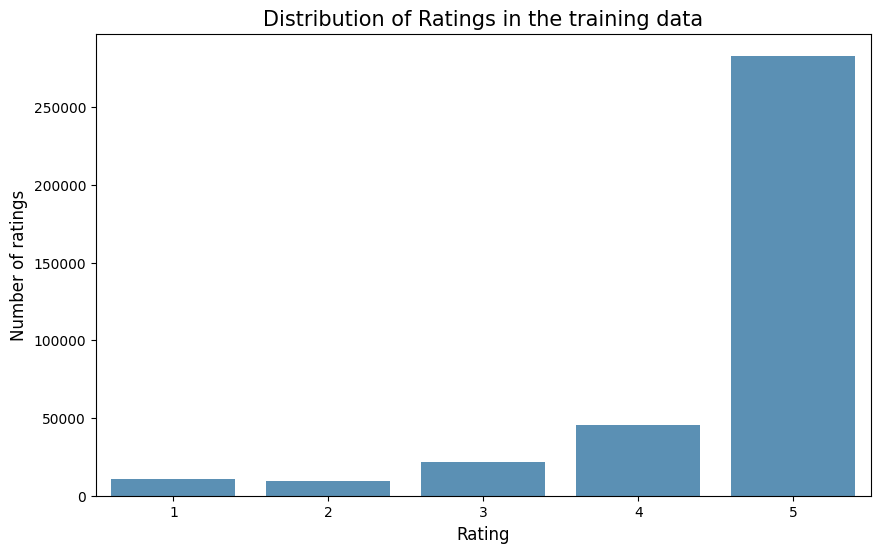

In [8]:
# plot the number of ratings for each rating
number = train['overall'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=number.index, y=number.values, alpha=0.8)
plt.title('Distribution of Ratings in the training data', fontsize=15)  
plt.ylabel('Number of ratings', fontsize=12)
plt.xlabel('Rating', fontsize=12)
plt.show()

- ### Pie chart of the percentage distribution of ratings

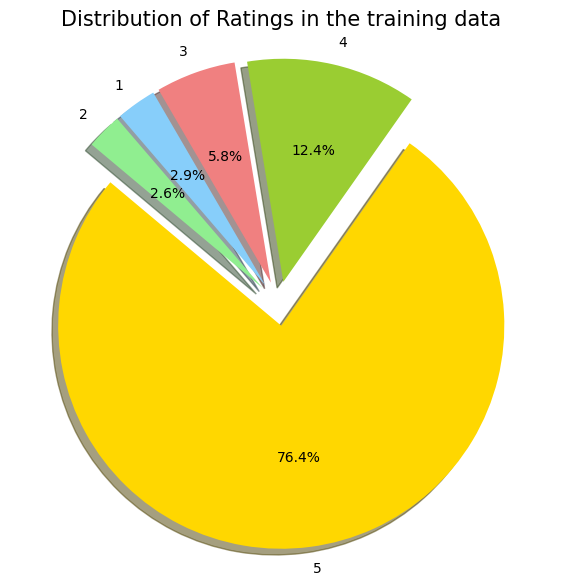

In [9]:
# pie chart
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen']
explode = (0.1, 0.1, 0.1, 0.1, 0.1)

plt.figure(figsize=(7, 7))
plt.pie(number.values, explode=explode, labels=number.index, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Ratings in the training data', fontsize=15)
plt.axis('equal')
plt.show()

#### Based on the above plot, we can see that the data is heavily imbalanced. The 5 star reviews comprise of 76.4% of the entire training data. To deal with this, we will use a <ins>weighted loss function proportional to the class imbalance</ins>, so that the model can learn from the minority classes as well.

### 3) <ins> Checking if data is shuffled

In [10]:
# number of unique ratings in first 10,000 reviews
train['overall'][:10000].value_counts()

overall
5    7691
4    1208
3     570
1     270
2     261
Name: count, dtype: int64

#### As we have different labels in the first 10,000 rows, we can conclude that the data is shuffled.

---

## <ins>Text Processing and Normalization

### 1) <ins> Text Processing Class

In [6]:
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.punctuations = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
        # self.spell = SpellChecker()

    def lowercase(self, text):
        return text.lower()
    
    def remove_punctuation(self, text):
        return text.translate(self.punctuations)
    
    def tokenize(self, text):
        return word_tokenize(text)

    def remove_stop_words(self, tokens):
        stop_words = set(stopwords.words("english"))
        return [word for word in tokens if word not in stop_words]
    
    def remove_numbers(self, tokens):
        return [word for word in tokens if not word.isdigit()]
    
    def POS_tagging(self, tokens):
        return pos_tag(tokens)
    
    #Function to convert nltk pos tags to wordnet pos tags
    def get_wordnet_pos(self, treebank_tag):
        try:
            if treebank_tag.startswith("J"):
                return wordnet.ADJ
            elif treebank_tag.startswith("V"):
                return wordnet.VERB
            elif treebank_tag.startswith("N"):
                return wordnet.NOUN
            elif treebank_tag.startswith("R"):
                return wordnet.ADV
            elif treebank_tag.startswith("P"):
                return wordnet.NOUN
            else:
                return ""
        except:
            print(treebank_tag, f" is not a valid treebank tag")
            return ""
    
    def lemmatize(self, pos_tags):
        lemmatized_tokens = []
        for token, pos_tag in pos_tags:
            wordnet_pos = self.get_wordnet_pos(pos_tag)
            lemma = (
                self.lemmatizer.lemmatize(token, pos=wordnet_pos)
                if wordnet_pos
                else self.lemmatizer.lemmatize(token)
            )
            lemmatized_tokens.append(lemma)
        return lemmatized_tokens
    
    #! function to correct spelling mistakes in the text
    # def correct_spelling(self, text):
    #     words = text.split()
    #     corrected_words = [(self.spell.correction(word) if self.spell.correction(word) else word) for word in words]
    #     corrected_sentence = ' '.join(corrected_words)
    #     return corrected_sentence

    
    #* function to expand contractions like "I'm" to "I am"
    def expand_contractions(self, text):
        return contractions.fix(text)
    
    #* function to remove words starting with a backslash like "\n" using regex
    def rem_backslash_words(self, text):
        # Replace HTML line breaks with space
        text = re.sub(r'<br\s*/?>', ' ', text)
        # Replace tabs and newlines with a space
        text = re.sub(r'\s+', ' ', text)
        # Optionally, strip leading/trailing whitespace
        text = text.strip()
        return text


    def preprocess(self, text):
        lower_text = self.lowercase(text)
        expanded_text = self.expand_contractions(lower_text)
        no_punc_text = self.remove_punctuation(expanded_text)
        no_backslash = self.rem_backslash_words(no_punc_text)
        # spell_checked = self.correct_spelling(no_backslash)
        tokens = self.tokenize(no_backslash)
        no_stop = self.remove_stop_words(tokens)
        no_numbers = self.remove_numbers(no_stop)
        pos_tags = self.POS_tagging(no_numbers)
        lemmatized = self.lemmatize(pos_tags)
        return lemmatized
    

pre_processor = TextPreprocessor()

# text = "helo, my naem is john \n\n \n \r \t"
# cleaned = PreProcessor.rem_backslash_words(text)
# print(cleaned)

In [7]:
# carrying out the preprocessing, and storing the tokens in another dataframe with columns 'pre_processed tokens' and 'overall'
train["tokenized"] = train["Review"].progress_apply(lambda x: pre_processor.preprocess(x))

processed_train = train[["tokenized", "overall"]]
processed_train.loc[:, "tokenized_joined"] = processed_train["tokenized"].progress_apply(lambda x: " ".join(x))

processed_train.head()

100%|██████████| 370855/370855 [00:00<00:00, 777311.01it/s]


,tokenized,overall,tokenized_joined
0,"[love, glitter, pen, sparkle, delightfully, pa...",5,love glitter pen sparkle delightfully page bri...
1,"[work, well, machine, use, mostly, cone]",5,work well machine use mostly cone
2,"[great, assortment, color, though, lot, pink, ...",5,great assortment color though lot pink mix sti...
3,[look],5,look
4,"[make, bird, hospital, month]",5,make bird hospital month


In [8]:
processed_train = processed_train[["tokenized", "tokenized_joined", "overall"]]
print(processed_train.shape)
processed_train.head()

(370855, 3)


,tokenized,tokenized_joined,overall
0,"[love, glitter, pen, sparkle, delightfully, pa...",love glitter pen sparkle delightfully page bri...,5
1,"[work, well, machine, use, mostly, cone]",work well machine use mostly cone,5
2,"[great, assortment, color, though, lot, pink, ...",great assortment color though lot pink mix sti...,5
3,[look],look,5
4,"[make, bird, hospital, month]",make bird hospital month,5


### 2) <ins>Discussion on the text processing and normalization techniques used

---

## <ins>Feature Representation

In [9]:
def document_vector(model, doc):
    doc = [word for word in doc if word in model.wv]
    if not doc:
        return np.zeros(model.vector_size)

    return np.mean(model.wv[doc], axis=0)


# function for creating representations of the text
def create_representations(representation):
    vectorizer = None
    if representation == "one_hot":
        vectorizer = CountVectorizer(binary=True)
    elif representation == "frequency":
        vectorizer = CountVectorizer()
    elif representation == "tf_idf":
        vectorizer = TfidfVectorizer()
    elif representation == "OneGram":
        vectorizer = CountVectorizer(ngram_range=(1, 1))
    elif representation == "TwoGram":
        vectorizer = CountVectorizer(ngram_range=(2, 2))
    elif representation == "ThreeGram":
        vectorizer = CountVectorizer(ngram_range=(3, 3))
    elif representation == "cbow":
        model = gensim.models.Word2Vec(
            processed_train["tokenized"].to_list(),
            min_count=1,
            vector_size=100,
            window=5,
        )
    elif representation == "skipgram":
        model = gensim.models.Word2Vec(
            processed_train["tokenized"].to_list(),
            min_count=1,
            vector_size=100,
            window=5,
            sg=1,
        )
    else:
        raise ValueError("Invalid representation type")

    if vectorizer == None and model:
        X_representation = np.array(
            [document_vector(model, doc) for doc in processed_train["tokenized"]]
        )
        np.savez_compressed(
            f"./representations/X_{representation}.npz", features=X_representation
        )
    else:
        X_representation = vectorizer.fit_transform(processed_train["tokenized_joined"])
        save_npz(f"./representations/X_{representation}.npz", X_representation)

In [10]:
representations = [
    #"one_hot",
    #"frequency",
    "tf_idf",
    "OneGram",
    "TwoGram",
    #"ThreeGram",
    "cbow",
    "skipgram",
]

for representation in tqdm(representations):
    create_representations(representation)

100%|██████████| 5/5 [03:15<00:00, 39.11s/it]


--- 

## Modelling

### SVM

In [19]:
# import SVC 


In [17]:
def train_model(model, hparams, representation):
    if representation == "cbow" or representation == "skipgram":
        X = np.load(f"./representations/X_{representation}.npz")["features"]
    else:
        X = load_npz(f"./representations/X_{representation}.npz")
    y = train["overall"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"Training {model} on {representation} representation")

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=hparams,
        n_iter=10,
        cv=5,
        verbose=4,
        n_jobs=-1,
        random_state=42,
    )

    # Fit RandomizedSearchCV on the training set
    random_search.fit(X_train, y_train)

    print(f"Training {model} on {representation} representation completed")

    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    
    y_pred = best_model.predict(X_test)
    accuracy = best_model.score(X_test, y_test)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    return best_model, best_params, accuracy, class_report, conf_matrix

In [18]:
hparams_SVC = {
    'C': reciprocal(0.1, 100),  # Regularization parameter
    'gamma': expon(scale=1.0),  # Kernel coefficient
    'kernel': ['rbf'],  # Assuming we're only interested in the RBF kernel here
    'max_iter': [100],
}

In [19]:
representations = [
    "tf_idf",
    "OneGram",
    "TwoGram",
    "cbow",
    "skipgram",
]

svc_dict = {}

for representation in tqdm(representations):
    best_model, best_params, accuracy, class_report, conf_matrix = train_model(SVC(), hparams_SVC, representation)
    svc_dict.update({
        f"{representation}_model": best_model,
        f"{representation}_params": best_params,
        f"{representation}_accuracy": accuracy,
        f"{representation}_class_report": class_report,
        f"{representation}_conf_matrix": conf_matrix,
    })    

  0%|          | 0/5 [00:00<?, ?it/s]

Training SVC() on tf_idf representation
Fitting 5 folds for each of 10 candidates, totalling 50 fits


  0%|          | 0/5 [00:06<?, ?it/s]


KeyboardInterrupt: 

---

In [7]:
import pickle

In [ ]:
# storing results in a pickle file
with open("svc_dict.pkl", "wb") as f:
    pickle.dump(svc_dict, f)

In [ ]:
# read from pickle and store in a dictionary
with open("svc_dict.pkl", "rb") as f:
    svc_dict = pickle.load(f)

In [ ]:
# print the class report for each representation
for key, value in svc_dict.items():
    if "class_report" in key:
        print(f"Class report for {key}:")
        print(value)

---

### Random Forest

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

#initialize a random forest classifier
rfc = RandomForestClassifier()

In [ ]:
hparams_RF = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=20)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(5, 120, num=12)] + [None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True],
    'max_samples': [0.5, 0.75, 0.25],  # Consider smaller fractions for large datasets
    'class_weight': ['balanced_subsample'],  # Important for imbalance
    'criterion': ['gini', 'entropy'],
}


In [ ]:
representations = [
    "tf_idf",
    "OneGram",
    "TwoGram",
    "cbow",
    "skipgram",
]

RF_dict = {}

for representation in tqdm(representations):
    best_model, best_params, y_pred, class_report, conf_matrix = train_model(RandomForestClassifier(), hparams_RF, representation)
    RF_dict.update({
        f"{representation}_model": best_model,
        f"{representation}_params": best_params,
        f"{representation}_y_pred": y_pred,
        f"{representation}_class_report": class_report,
        f"{representation}_conf_matrix": conf_matrix,
    })    

---

### MLP

In [1]:
# creating a train_test split for a given representation
def create_train_test(representation):
    if representation == "cbow" or representation == "skipgram":
        X = np.load(f"./representations/X_{representation}.npz")["features"]
    else:
        X = load_npz(f"./representations/X_{representation}.npz")
    y = train["overall"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test

epochs = 10

In [2]:
def sparse_predict_generator(X, batch_size=32):
    n_samples = X.shape[0]

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        X_batch = X[start:end].toarray()

        yield X_batch

In [3]:
def sparse_generator(X, y, batch_size=32, epochs=epochs):
    """
    A generator for batches of sparse data.

    Parameters:
    - X: Sparse feature matrix (scipy.sparse matrix).
    - y: Labels (numpy array).
    - batch_size: Size of batches to generate.
    """
    n_samples = X.shape[0]

    # Shuffle data indices for each epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for _ in range(epochs):
        indices = np.arange(n_samples)

        for start_idx in range(0, n_samples, batch_size):
            batch_indices = indices[start_idx : start_idx + batch_size]

            # Convert the sparse batch to a dense format as TensorFlow expects dense arrays
            X_batch = X[batch_indices].toarray()  # Convert sparse matrix part to dense
            y_batch = y[batch_indices]

            yield X_batch, y_batch

In [22]:
def train_model_tfIdf():
    X_train, X_test, y_train, y_test = create_train_test("tf_idf")
    input_dim = X_train.shape[1]
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))  # Add dropout for regularization
    model.add(BatchNormalization())  # Normalize the activations of the first layer

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))  # Add dropout for regularization
    model.add(BatchNormalization())  # Normalize the activations

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))  # Slightly lower dropout
    model.add(BatchNormalization())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))  # Further lower dropout
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax')) 

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

    y_train_adjusted = y_train - 1
    y_test_adjusted = y_test - 1

    y_train_one_hot = to_categorical(y_train_adjusted)
    y_test_one_hot = to_categorical(y_test_adjusted)

    batch_size = 32
    step_size = X_train.shape[0] // batch_size
    step_size_test = X_test.shape[0] // batch_size
    epochs = 10

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_adjusted), y=y_train_adjusted)
    class_weights_dict = dict(enumerate(class_weights))
    
    # Training the model with class weights
    history = model.fit(sparse_generator(X_train, y_train_one_hot), steps_per_epoch=step_size, epochs=epochs, class_weight=class_weights_dict, validation_data=sparse_generator(X_test, y_test_one_hot), validation_steps =step_size_test, verbose=1)

    return model, history
    

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/10
9271/9271 [==============================] - 202s 21ms/step - loss: 1.3502 - accuracy: 0.5515 - val_loss: 3.3012 - val_accuracy: 0.5323
Epoch 2/10
9271/9271 [==============================] - 201s 22ms/step - loss: 1.2536 - accuracy: 0.5792 - val_loss: 26.6354 - val_accuracy: 0.5434
Epoch 3/10
9271/9271 [==============================] - 199s 21ms/step - loss: 1.2067 - accuracy: 0.5907 - val_loss: 7.7870 - val_accuracy: 0.5486
Epoch 4/10
9271/9271 [==============================] - 198s 21ms/step - loss: 1.1704 - accuracy: 0.5931 - val_loss: 4661.6348 - val_accuracy: 0.6087
Epoch 5/10
9271/9271 [==============================] - 197s 21ms/step - loss: 1.1430 - accuracy: 0.5994 - val_loss: 6.3673 - val_accuracy: 0.5618
Epoch 6/10
9271/9271 [==============================] - 200s 22ms/step - loss: 1.1177 - accuracy: 0.6070 - val_loss: 92.8148 - val_accuracy: 0.5789
Epoch 7/10
9271/9271 [==============================] - 200s 22ms/step - loss: 1.0878 - accuracy: 0.6112 - val_lo

 33%|███▎      | 1/3 [33:31<1:07:02, 2011.28s/it]


ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul]

---

In [16]:
from gensim.models import Word2Vec

In [ ]:
processed_train = pd.read_pickle("processed_train.pkl")

In [18]:
tokenized_texts = processed_train['tokenized'].tolist()

skipgram = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, sg=1, min_count=2)

In [19]:
vocab_size = len(skipgram.wv.key_to_index) + 1  # Adding 1 to account for padding token
embedding_dim = 100  # Or the vector_size you used for your Skip-gram model

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in skipgram.wv.key_to_index.items():
    embedding_vector = skipgram.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=vocab_size-1)  # vocab_size minus 1 to account for padding token
tokenizer.fit_on_texts(processed_train['tokenized_joined'].tolist())

# Convert texts to sequences of integers
sequences = tokenizer.texts_to_sequences(processed_train['tokenized_joined'].tolist())

# Pad sequences to ensure uniform length
max_length = max(len(seq) for seq in sequences)  # Or choose a max_length that suits your dataset
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False, input_length=max_length))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(5, activation='softmax'))  # For 5 classes

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
y = processed_train['overall'] - 1  # Adjust labels to 0-based index

In [25]:
history = model.fit(padded_sequences, y, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
9272/9272 [==============================] - 3090s 333ms/step - loss: 0.8284 - accuracy: 0.7636 - val_loss: 0.8293 - val_accuracy: 0.7631
Epoch 2/20
9272/9272 [==============================] - 3062s 330ms/step - loss: 0.8275 - accuracy: 0.7636 - val_loss: 0.8294 - val_accuracy: 0.7631
Epoch 3/20
9272/9272 [==============================] - 3046s 328ms/step - loss: 0.8273 - accuracy: 0.7636 - val_loss: 0.8286 - val_accuracy: 0.7631
Epoch 4/20
9272/9272 [==============================] - 3068s 331ms/step - loss: 0.8272 - accuracy: 0.7636 - val_loss: 0.8284 - val_accuracy: 0.7631
Epoch 5/20
9272/9272 [==============================] - 3081s 332ms/step - loss: 0.8271 - accuracy: 0.7636 - val_loss: 0.8289 - val_accuracy: 0.7631
Epoch 6/20
9272/9272 [==============================] - 3091s 333ms/step - loss: 0.8271 - accuracy: 0.7636 - val_loss: 0.8289 - val_accuracy: 0.7631
Epoch 7/20
9272/9272 [==============================] - 3081s 332ms/step - loss: 0.8270 - accuracy: 0.7636

KeyboardInterrupt: 